# Capstone Final Project - The Battle of Neighborhoods

In [8]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Essential Libraries importing DONE.')

Essential Libraries importing DONE.


Making a function to get the geocodes: latitude and longitude of a given location using geopy.

In [11]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Making a Function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [73]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100


    CLIENT_ID = "CLIENT_ID"
    CLIENT_SECRET = "CLIENT_SECRET"
    VERSION = 20190101
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    #print(results)
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

And now defining a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [74]:
def get_venue_details(venue_id):
        
    
    CLIENT_ID = "ClientID"
    CLIENT_SECRET = "SecretId"
    
    VERSION = 20190101
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
   # print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [29]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [30]:
# get new york data
new_york_data=get_new_york_data()

In [118]:
new_york_data.to_csv("NewYorkLocationdata.csv")

In [31]:
# Display first 10 records
new_york_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [33]:
# Get the shape of the dataset
new_york_data.shape

(306, 4)

We Got 306 different neighbourhoods in New York

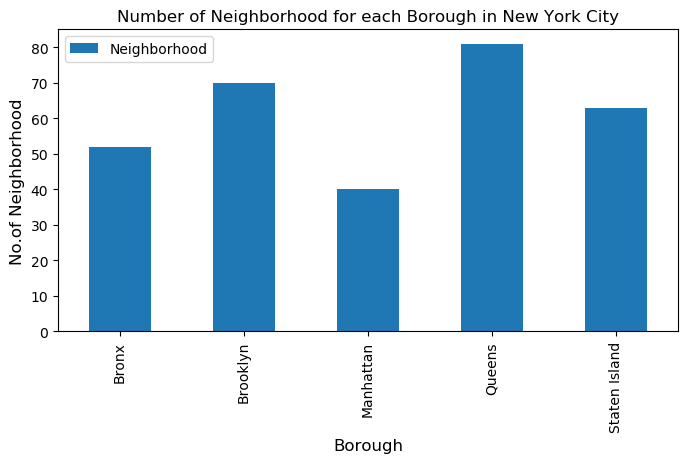

In [34]:
plt.figure(figsize=(8,4), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=12)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## Observations: 

The Borough Queens is having highest number of neighborhoods in New York


Data collection:
Now we will collect Indian resturants for each Neighborhood

In [45]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:1
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [46]:
#Dispaly first 5 records
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Parkchester,55dfa36a498e164ef19bef7b,Premium Sweets & Restaurant
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [47]:
#getting the shape of the dataset
indian_rest_ny.shape

(153, 4)

We have got 153 Indian Resturants across New York City

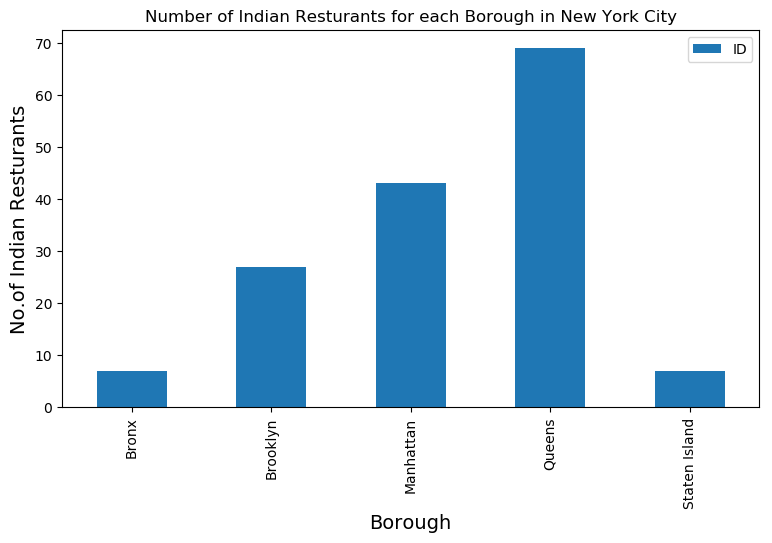

In [48]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 14)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=14)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We could notice Queens has the largest number of indian resturants

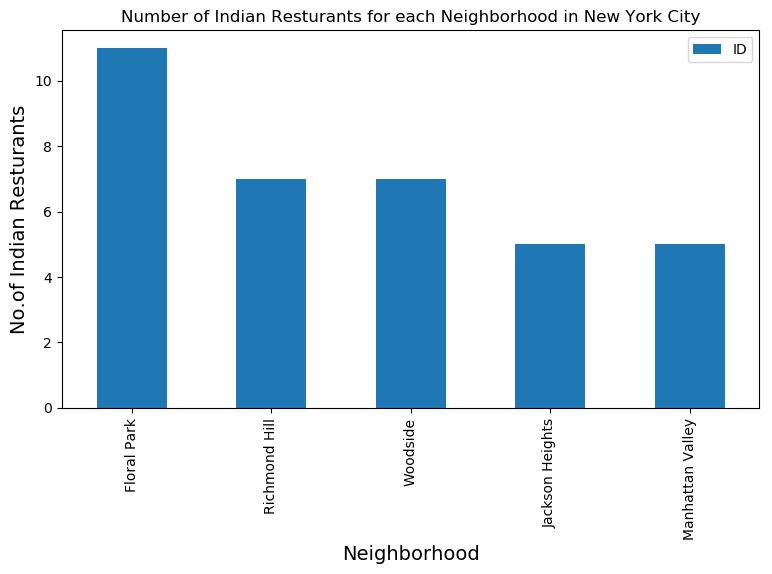

In [49]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 14)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=14)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [50]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
100,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
101,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
102,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
103,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
104,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
105,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
106,Queens,Floral Park,4c953a7672dd224bd8d1a191,Real Usha Sweets & Snacks Inc.
107,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
108,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
109,Queens,Floral Park,5d06c43cc03635002cc463f2,Honest


In [70]:
indian_rest_ny.to_excel("Indian_Restaurant_NY.xlsx")

So Floral Park in Queens has the highest number of Indian Resturants with a total count of 11.

Now we will get the ranking of each resturant for further analysis

In [ ]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)

Exporting the dataset to csv file to avoid repeated run of above code.

In [76]:
indian_rest_stats_ny.to_csv('Indian_Restaurant_NY.csv', index=False)

In [78]:
#Reading th file
indian_rest_stats_ny=pd.read_csv('Indian_Restaurant_NY.csv')

In [79]:
indian_rest_stats_ny.head()

,Unnamed: 0,Borough,Neighborhood,ID,dd,Name,Likes,Rating,Tips
0,0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,1,Curry Spot,5.0,8.0,11.0
1,1,Bronx,Parkchester,4c194631838020a13e78e561,2,Melanies Roti Bar And Grill,3.0,5.9,2.0
2,2,Bronx,Parkchester,55dfa36a498e164ef19bef7b,1,Premium Sweets & Restaurant,18.0,7.4,5.0
3,3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,1,Cumin Indian Cuisine,13.0,6.0,9.0
4,4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,2,Hungry Bird,8.0,6.9,3.0


In [80]:
indian_rest_stats_ny.shape

(153, 9)

In [84]:
indian_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 9 columns):
Unnamed: 0      153 non-null int64
Borough         153 non-null object
Neighborhood    153 non-null object
ID              153 non-null object
dd              153 non-null int64
Name            153 non-null object
Likes           152 non-null float64
Rating          139 non-null float64
Tips            152 non-null float64
dtypes: float64(3), int64(2), object(4)
memory usage: 10.8+ KB


Lets start analyzing the Data

In [85]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Unnamed: 0                            41
Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
dd                                     2
Name               The Kati Roll Company
Likes                                836
Rating                               8.7
Tips                                 259
Name: 41, dtype: object

In [86]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Unnamed: 0                            56
Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
dd                                     1
Name                 Seva Indian Cuisine
Likes                                231
Rating                               9.2
Tips                                 126
Name: 56, dtype: object

In [87]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Unnamed: 0                            41
Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
dd                                     2
Name               The Kati Roll Company
Likes                                836
Rating                               8.7
Tips                                 259
Name: 41, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [104]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [105]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Astoria,9.200000
6,Blissville,9.200000
64,Sunnyside,9.200000
68,Tribeca,9.000000
12,Civic Center,9.000000
30,Greenwich Village,8.900000
28,Gramercy,8.866667
74,West Village,8.850000
13,Clinton Hill,8.700000
42,Midtown,8.700000


Above are the top neighborhoods with top average rating of Indian resturants

In [113]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

Similarly these are the average rating of Indian Resturants for each Borough

In [114]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.264286
4,Staten Island,7.900000
3,Queens,7.644068
1,Brooklyn,7.318519
0,Bronx,6.714286


Data Visualization

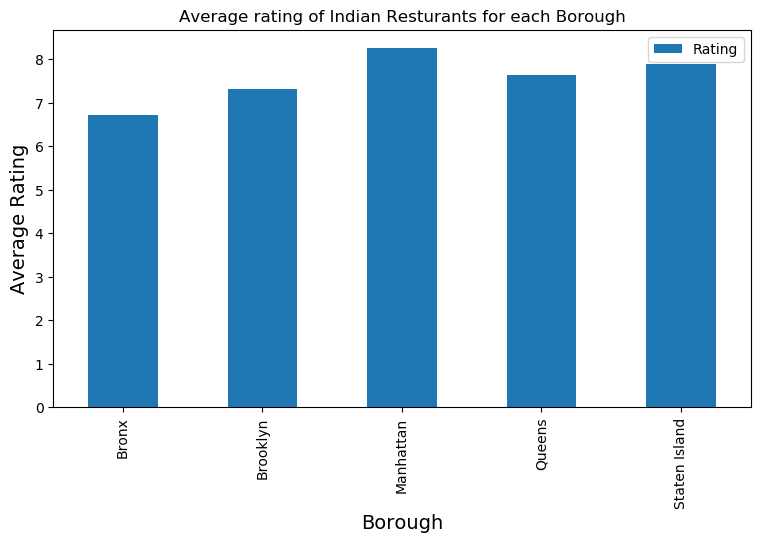

In [110]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 14)
#On y-axis
plt.ylabel('Average Rating', fontsize=14)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater than 8.5 to visualize on map

In [116]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>8.5]

In [117]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,9.200000
6,Blissville,9.200000
12,Civic Center,9.000000
13,Clinton Hill,8.700000
23,Fort Greene,8.700000
28,Gramercy,8.866667
30,Greenwich Village,8.900000
42,Midtown,8.700000
45,Murray Hill,8.600000
63,Steinway,8.600000


We will join this dataset to original new york data to get lonitude and latitude

In [119]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [120]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [121]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,9.200000
1,Queens,Blissville,40.737251,-73.932442,9.200000
2,Manhattan,Civic Center,40.715229,-74.005415,9.000000
3,Brooklyn,Clinton Hill,40.693229,-73.967843,8.700000
4,Brooklyn,Fort Greene,40.688527,-73.972906,8.700000
5,Manhattan,Gramercy,40.737210,-73.981376,8.866667
6,Manhattan,Greenwich Village,40.726933,-73.999914,8.900000
7,Manhattan,Midtown,40.754691,-73.981669,8.700000
8,Manhattan,Murray Hill,40.748303,-73.978332,8.600000
9,Queens,Murray Hill,40.764126,-73.812763,8.600000


Now we will plot this data on a map

In [122]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [123]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [124]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [132]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Queens,Astoria,40.768509,-73.915654,9.200000,"Astoria, Queens(9.2)"
1,Queens,Blissville,40.737251,-73.932442,9.200000,"Blissville, Queens(9.2)"
2,Manhattan,Civic Center,40.715229,-74.005415,9.000000,"Civic Center, Manhattan(9.0)"
3,Brooklyn,Clinton Hill,40.693229,-73.967843,8.700000,"Clinton Hill, Brooklyn(8.7)"
4,Brooklyn,Fort Greene,40.688527,-73.972906,8.700000,"Fort Greene, Brooklyn(8.7)"
5,Manhattan,Gramercy,40.737210,-73.981376,8.866667,"Gramercy, Manhattan(8.866666666666667)"
6,Manhattan,Greenwich Village,40.726933,-73.999914,8.900000,"Greenwich Village, Manhattan(8.9)"
7,Manhattan,Midtown,40.754691,-73.981669,8.700000,"Midtown, Manhattan(8.7)"
8,Manhattan,Murray Hill,40.748303,-73.978332,8.600000,"Murray Hill, Manhattan(8.6)"
9,Queens,Murray Hill,40.764126,-73.812763,8.600000,"Murray Hill, Queens(8.6)"


Visualize the Neighborhoods. 

In [125]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Lets Visualize Boroughs based on average Rating

In [129]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file to local
ny_map.save('borough_rating.html')

In [130]:
ny_borough_stats

,Borough,Average Rating
0,Bronx,6.714286
1,Brooklyn,7.318519
2,Manhattan,8.264286
3,Queens,7.644068
4,Staten Island,7.900000
